# <span style = "color:green"> Emotions in Text Prediction with LSTM </span>

***

### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Read the dataset

In [2]:
df = pd.read_csv('Emotion_final.csv')

In [3]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


### Print some of the texts along with its emotions

In [4]:
for i in range(10):
    print(df['Text'][i],'-', df['Emotion'][i])
    print()

i didnt feel humiliated - sadness

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake - sadness

im grabbing a minute to post i feel greedy wrong - anger

i am ever feeling nostalgic about the fireplace i will know that it is still on the property - love

i am feeling grouchy - anger

ive been feeling a little burdened lately wasnt sure why that was - sadness

ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny - surprise

i feel as confused about life as a teenager or as jaded as a year old man - fear

i have been with petronas for years i feel that petronas has performed well and made a huge profit - happy

i feel romantic too - love



### View info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


### View basic statistical information about the dataset

In [6]:
df.describe()

,Text,Emotion
count,21459,21459
unique,21405,6
top,i feel so tortured by it,happy
freq,2,7029


### Check for null values

In [7]:
df.isna().sum()

Text       0
Emotion    0
dtype: int64

### Check for duplicated values

In [8]:
df.duplicated().sum()

3

In [9]:
df.drop_duplicates(inplace= True, keep = 'first')

### Plot a countplot of 'Emotions'

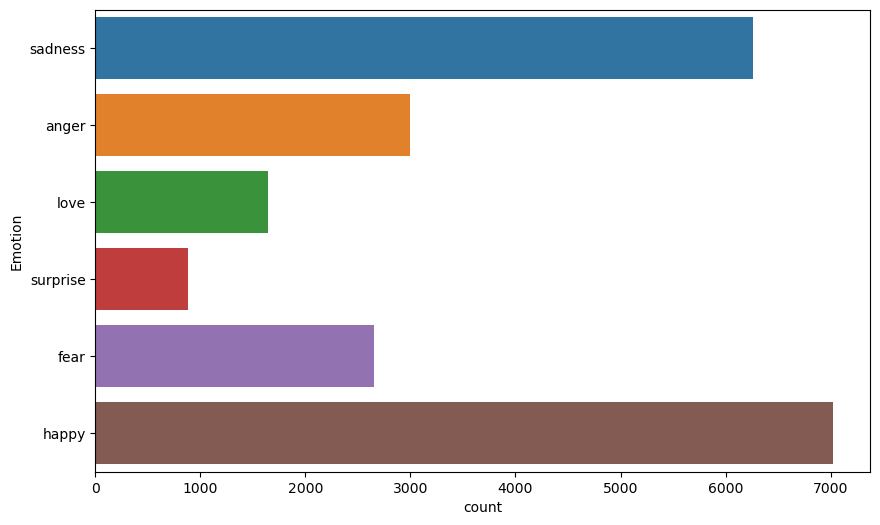

In [10]:
plt.figure(figsize = (10,6))
sns.countplot(y = df['Emotion'])
plt.show()

### Create a function to preprocess the text

In [11]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [12]:
def preprocess(sentence):
    #removes all the special characters and split the sentence at spaces
    text = re.sub(r"[^a-zA-Z0-9]"," ",sentence).split()
    
    # converts words to lowercase and removes any stopwords
    words = [x.lower() for x in text if x not in stopwords.words('english')]
    
    # Lemmatize the words
    lemma = WordNetLemmatizer()
    word = [lemma.lemmatize(word,'v') for word in words ]
    
    # convert the list of words back into a sentence
    word = ' '.join(word)
    return word

### Apply the function on Text column

In [13]:
df['Text'] = df['Text'].apply(preprocess)

### Print some of the texts after the preprocess

In [14]:
for i in range(10):
    print(df['Text'][i])
    print()

didnt feel humiliate

go feel hopeless damn hopeful around someone care awake

im grab minute post feel greedy wrong

ever feel nostalgic fireplace know still property

feel grouchy

ive feel little burden lately wasnt sure

ive take milligrams time recommend amount ive fall asleep lot faster also feel like funny

feel confuse life teenager jade year old man

petronas years feel petronas perform well make huge profit

feel romantic



### Split the dataset into Input and Target Variables

In [15]:
X = df['Text']
y = df['Emotion']

### One Hot encode the Target variables

In [16]:
from sklearn.preprocessing import LabelBinarizer

In [17]:
encoder = LabelBinarizer()
y = encoder.fit_transform(y)

### Check encoder classes

In [18]:
labels = encoder.classes_
labels

array(['anger', 'fear', 'happy', 'love', 'sadness', 'surprise'],
      dtype='<U8')

### Split the dataset into Training and Testing Set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20)

### Convert text to Sequence and add padding

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [21]:
tokenizer = Tokenizer(num_words=5000)

#### "fit_on_texts" - This method creates the vocabulary index based on word frequency. Each word gets a unique id

In [22]:
tokenizer.fit_on_texts(X_train)

In [23]:
vocab_size = len(tokenizer.word_index) + 1

In [24]:
tokenizer

In [25]:
def text_encoding(txt):
    # texts_to_sequences Transforms each text in texts to a sequence of integers.
    encoded_docs = tokenizer.texts_to_sequences(txt)
    
    # pad_sequences is used to ensure that all sequences in a list have the same length.
    padded_sequence = pad_sequences(encoded_docs, maxlen=128)    
       
    return padded_sequence

### Apply the function on both Training and Testing set

In [26]:
X_train = text_encoding(X_train)
X_test = text_encoding(X_test)

### Create a keras Sequential model with LSTM Layers

In [27]:
vocab_size

13928

In [28]:
from keras import Sequential
from keras import layers

### Embedding layer:
 * Vocab size: Number of unique words in our training set
 * Second argument (In this case "128" is the size of each embedding vectors

In [29]:
model = Sequential()
### Embedding layer
model.add(layers.Embedding(vocab_size, 128))

### Lstm layer
### return_sequences: Whether to return the last output in the output sequence, or the full sequence.
model.add(layers.LSTM(128,  return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(128))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(6, activation='softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1782784   
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

### Compile the model

In [31]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Train the model

In [32]:
model.fit(X_train, y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
430/430 [==============================] - 82s 184ms/step - loss: 1.1034 - accuracy: 0.5752 - val_loss: 0.4787 - val_accuracy: 0.8319
Epoch 2/10
430/430 [==============================] - 80s 187ms/step - loss: 0.2954 - accuracy: 0.8984 - val_loss: 0.2840 - val_accuracy: 0.8908
Epoch 3/10
430/430 [==============================] - 81s 189ms/step - loss: 0.1559 - accuracy: 0.9428 - val_loss: 0.2803 - val_accuracy: 0.9007
Epoch 4/10
430/430 [==============================] - 79s 183ms/step - loss: 0.1068 - accuracy: 0.9571 - val_loss: 0.2993 - val_accuracy: 0.8896
Epoch 5/10
430/430 [==============================] - 86s 201ms/step - loss: 0.0848 - accuracy: 0.9655 - val_loss: 0.3323 - val_accuracy: 0.8937
Epoch 6/10
430/430 [==============================] - 128s 297ms/step - loss: 0.0752 - accuracy: 0.9713 - val_loss: 0.3382 - val_accuracy: 0.8951
Epoch 7/10
430/430 [==============================] - 82s 190ms/step - loss: 0.0609 - accuracy: 0.9769 - val_loss: 0.3679 - val_a

### Make Prediction with X_test

In [33]:
y_pred = model.predict(X_test)

135/135 [==============================] - 7s 47ms/step


In [34]:
y_pred = [np.argmax(i) for i in y_pred]

In [35]:
len(y_pred)

4292

In [36]:
len(y_test)

4292

In [37]:
y_test = [np.argmax(i) for i in y_test]

### Model Evaluation

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#### Accuracy score

In [39]:
accuracy_score(y_test, y_pred)

0.8984156570363467

### Confusion Matrix

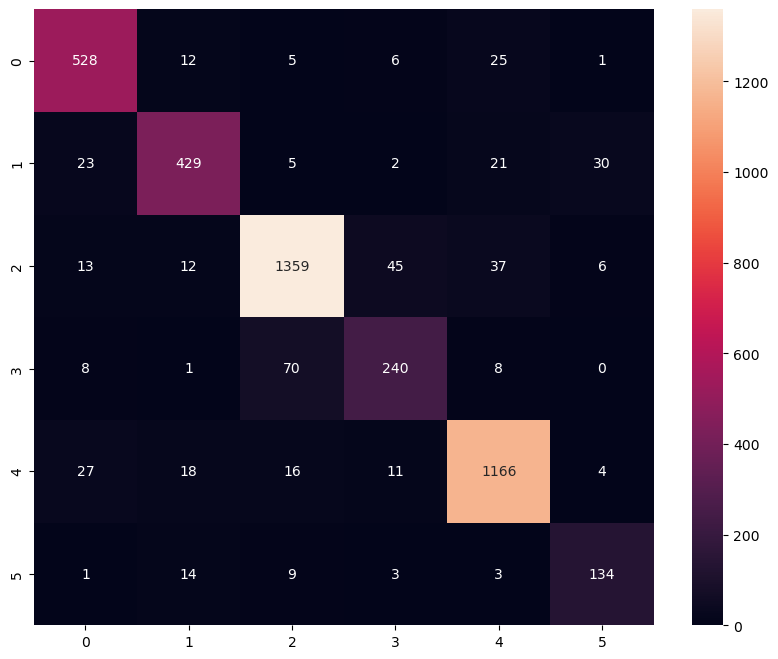

In [40]:
plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd')
plt.show()

### Classification report

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       577
           1       0.88      0.84      0.86       510
           2       0.93      0.92      0.93      1472
           3       0.78      0.73      0.76       327
           4       0.93      0.94      0.93      1242
           5       0.77      0.82      0.79       164

    accuracy                           0.90      4292
   macro avg       0.86      0.86      0.86      4292
weighted avg       0.90      0.90      0.90      4292



In [42]:
labels = dict(enumerate(encoder.classes_))

In [43]:
labels

{0: 'anger', 1: 'fear', 2: 'happy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [44]:
test = text_encoding(['This is a test sentence'])

In [45]:
result = model.predict([test])

1/1 [==============================] - 1s 507ms/step


In [46]:
result = np.argmax(model.predict)

In [47]:
labels[np.argmax(model.predict([test]))]

1/1 [==============================] - 0s 22ms/step


'happy'

### Create a function that inputs text and outputs the prediction

In [48]:
def prediction(text):
    sequence = text_encoding([text])
    pred = model.predict([sequence])
    pred = np.argmax(pred)
    pred = labels[pred]
    return pred

In [49]:
prediction('I am a very happy person')

1/1 [==============================] - 0s 25ms/step


'happy'

 ***